<a href="https://colab.research.google.com/github/ShrimanthAM/DeepLearningClass/blob/master/Chapter_8_Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision import transforms


from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm



import os
from imageio import imread
from glob import glob
import json

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pandas as pd

from sklearn.metrics import accuracy_score

import time

from mpdl import set_seed
from mpdl import train_network, Flatten, View, weight_reset, moveTo

In [ ]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

from IPython.display import display_pdf
from IPython.display import Latex

torch.backends.cudnn.deterministic=True
set_seed(42)

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") 

At this point in the book you now know how to build an effective image classification model for most problems you may run into. A combination of data augmentation, better optimizers, and Residual Networks, is an effective combination and a good starting point. But all of the methods and examples we have looked at assume that _the image is of a desired class_. For MNIST this means we assume that an image _always_ contains a digit, and the digit is one of 0 through 9. But what do you do if it is possible that an image might be empty? Even worse, what happens if there are _multiple_ digits within an image? What we want is a way to detect _where_ and _what_ is contained _within a single image_. 


Think about this example: you want to build a system that counts the different kinds of birds in a park. You point a camera at the sky, and for each bird, you want to know what kind of bird it was (classification). But what if there are no birds in the sky? Or just one? Or twelve? The first step is you need to _detect_ each bird in the image, and then classify each detected bird!

We will learn about two approaches that have been used for these kinds of tasks. First we will go into the details of _image segmentation_, which is an expensive but simpler approach. Similar to how autoregressive models from last chapter made a prediction for _every_ item in a sequence, image segmentation will make a prediction for _every_ pixel in an image! This is an effective approach but can be difficult due to the high cost of labeling images this way! To help work around this problem we will learn about bounding box based object detection, where labels are boxes that are _just_ large enough to capture a whole object within an image. This is easier to label, but effective object detection models are difficult to implement and expensive to train. We will learn about the Region Proposal based detector that is built into PyTorch due to it's wide spread use and ready availability. 



# Image Segmentation

One approach to finding  objects in an image is to do _image segmentation_. The image segmentation tasks is to take an input image (e.g., below its a person riding a horse), and identify a pre-determined set of semantic/meaningful labels for the things in the image. For instance, the input image below has a horse, a person, and some cars, as meaningful semantic objects. 

![Example of an input image (on the left) with the segmented ground-truth labels (on the right) from the PASCAL VOC 2012 dataset. Every pixel has been been given a class, with a default "no class" or "background" class given to pixels that are not apart of a labeled object. ](https://drive.google.com/uc?export=view&id=1tXaskXPIOQtQusB0mp-99x8WmCTQI0vI "Image Segmentation")

The goal is to produce the "Ground Truth", were _every pixel_ is classified as belonging to either a person, horse, car, or background! So in the case above we actually have a classification problem with four unique classes. It just happens to be that a single input involves making many predictions. So if we have a $128\times128$ image, we would have $128^2 = 16,384$ classifications to perform!

If we can successfully segment an image, we can then perform some  object detection! For the above image, we can find the person "blob" (pink pixels connected together) to determine that a person exists in the image, and where they exist within it! Segmentation can also be the goal in-and-of itself. For example, doctors may want to identify the percentage of tumor cells in an image of a cell biopsy to determine how someones cancer is progressing (larger percentage than before means its growing and getting worse, smaller percentage means the cancer is shrinking and treatment is working). Another common task in medical research is to manual label the number of different types of cells in an image and use the relative amounts of cell types to determine the overall health or other medical properties of a patient. These are tasks where we don't just want to know were objects are, but we want to know precisely how big they are and their relative proportions within an image. 

The task of image segmentation is a great opportunity to use a convolutional neural network.  A CNN is designed to produce _local_ outputs for a _local_ region of the input. So our strategy for designing a image segmentation network will use convolutional layers as the output layer too, instead of using a `nn.Linear` layer like we did before. When we design a network that contains only convolutional layers (in addition to a non-linearity, and normalization layers) we call that network _fully convolutional_ \footnote{Some people get upset when you call a model fully convolutional but still use pooling layers. I consider this nit-picking. In general any network that uses only convolutions and has no `nn.Linear` layers (or some other non-convolutional layer like an RNN) would be fine to call fully convolutional. }. 

## Nuclei Detection

For our first introduction to image segmentation, we are going to use data from the 2018 Data Science Bowl. The goal of this competition was to detect Nuclei of cells and their respective sizes. But we will be simplifying it to just segmenting the image for now! We will download this dataset, set up a Dataset class for the problem, and then specify a fully convolutional network to make predictions about the entire image. The below code is going to download the dataset for us, and unzip it onto the file system. 

In [ ]:
data_url_zip = "https://github.com/kamalkraj/DATA-SCIENCE-BOWL-2018/blob/master/data/stage1_train.zip?raw=true"
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
import re

#Download this dataset if we have not already done so! 
if not os.path.isdir('./data/stage1_train'):
    resp = urlopen(data_url_zip)
    os.mkdir("./data/stage1_train")
    zipfile = ZipFile(BytesIO(resp.read()))
    zipfile.extractall(path = './data/stage1_train')
#Grab all the paths to the images we just unziped 
paths = glob("./data/stage1_train/*")

The data is organized into a number of paths. So if we have the path/folder `data0`, an image of a cell under a microscope will be found in the path `data0/images/some_file_name.png`. For every nuclei in the image, there will be a file under `data0/masks/name_i.png`. The Dataset object below will load that in for us so we can get started. To make tings simple for now, we are going to do some normalization and prep inside the dataset class. We will remove an "alpha" channel that comes with these images (usually for transparent images), re-order the channels to be the first dimension like PyTorch likes, and compute the label for each input. 

The dataset provides an image of the same shape for each nuclei we are supposed to detect. To build a label we want an image that is the same shape, with "0" for no class and "1" for a nuclei being present. We can do this by converting each image to an array of binary values, called a "mask", where 1 = `True` = nuclei present. Then we can do a logical `or` operation on the masks to get one final mask that as a "1" at every pixel where a nuclei was present! 

Finally, to make life easier we will also re-scale each image to have a width and height of 256 pixels. This makes it easier for us to implement our `DataLoader` because we don't have to worry about padding images to all be the same size! 

In [ ]:
class DSB2018(Dataset):
    """Dataset class for the 2018 Data Science Bowl."""

    def __init__(self, paths):
        """
        paths: a list of paths to every image folder in the dataset
        """
        self.paths = paths

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        
        #There is only one image in each images path
        #So we will grab the "first" thing we find with 
        #"[0]" at the end
        img_path = glob(self.paths[idx] + "/images/*")[0]
        
        #but there are multiple mask images in each mask path!
        mask_imgs = glob(self.paths[idx] + "/masks/*")
        
        #the image shape is (W, H, 4), the last dimension 
        #is an 'alpha' channel that is not used
        img = imread(img_path)[:,:,0:3]#trim off the alpha so we get (W, H, 3)

        #Now we want this as (3, W, H), which is the normal shape for PyTorch
        img = np.moveaxis(img, -1, 0)
        #Last step for the image, re-scale it to the range [0, 1]
        img = img/255.0
        
        
        #Every mask image is going to have a shape of (W, H)
        #which has a value of 1 if the pixel is of a nuclei,
        #and a value of 0 if the image is background/ a 
        #_different_ nuclei
        masks = [imread(f)/255.0 for f in mask_imgs]
        
        #Since we want to do simple segmentation, 
        #we will create one final mask that contains
        #_all_ nuclei pixels from _every_ mask!
        final_mask = np.zeros(masks[0].shape)
        for m in masks:
            final_mask = np.logical_or(final_mask, m)
        final_mask = final_mask.astype(np.float32)
        
        #Not every image in the dataset is the same size. 
        #To simplify the problem, we are going to re-size 
        #every image to be (256, 256)
        
        #First we convert to PyTorch tensors
        img, final_mask = torch.tensor(img), torch.tensor(final_mask).unsqueeze(0)
        #the interpolate function can be used to re-size a batch of images
        #So we make each image a "batch" of 1
        img = F.interpolate(img.unsqueeze(0), (256, 256))
        final_mask = F.interpolate(final_mask.unsqueeze(0), (256, 256))
        #Now the shapes  are (B=1, C, W, H)
        #We need to convert them back to FloatTensors and grab the first item
        #in the "batch". This will return a tuple of:
        #(3, 256, 256), (1, 256, 256)
        return img.type(torch.FloatTensor)[0], final_mask.type(torch.FloatTensor)[0]

In [ ]:
#Create the Dataset class object
dsb_data = DSB2018(paths)

Now that we have loaded the dataset, lets visualize some of the data that is inside it! The corpus has cell images from a variety of sources, some looking like they are black-and-white, while others have some color from the dye used. On the left hand side you can see the original image, and on the right the mask that shows exactly where all the nuclei are. 

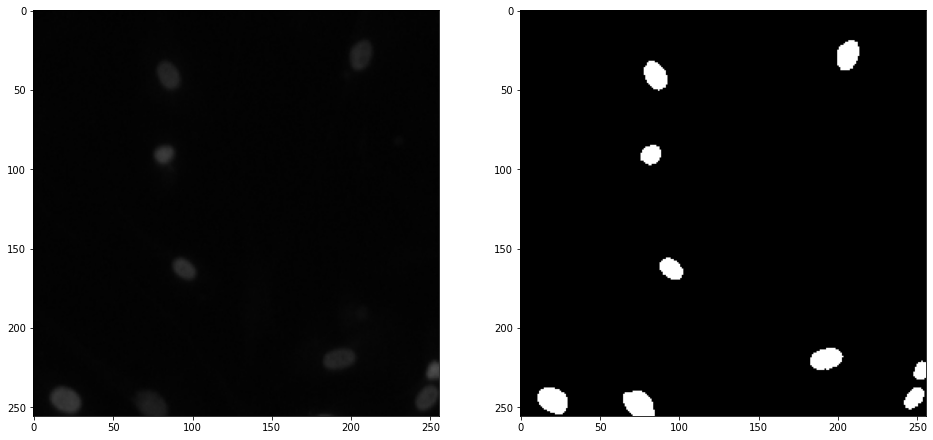

In [ ]:
plt.figure(figsize=(16,10))
#Plot the original image
plt.subplot(1, 2, 1)
plt.imshow(dsb_data[0][0].permute(1,2,0).numpy())
#Plot the mask
plt.subplot(1, 2, 2)
plt.imshow(dsb_data[0][1].numpy()[0,:], cmap='gray')

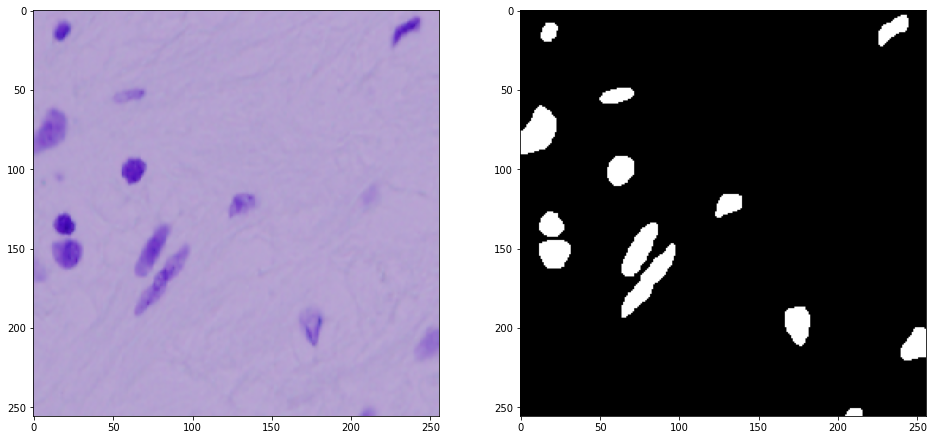

In [ ]:
plt.figure(figsize=(16,10))
plt.subplot(1, 2, 1)
plt.imshow(dsb_data[1][0].permute(1,2,0).numpy())
plt.subplot(1, 2, 2)
plt.imshow(dsb_data[1][1].numpy()[0,:], cmap='gray')

As we can see in the data, you there are a number of different types of input image slices. Some have many nuclei, some have few, and they can be close or far apart! Lets quickly crate a training and testing split to work with, and we will use a smaller batch size of just 16 images. I'm doing a smaller batch because these images are larger, 256 $\times$ 256 instead of just $28 \times 28$, and I want to make sure the batches will still fit onto your GPU even if Colab gives you one of the smaller instances. 

In [ ]:
train_split, test_split = torch.utils.data.random_split(dsb_data, [500, len(dsb_data)-500])
train_seg_loader = DataLoader(train_split, batch_size=16, shuffle=True)
test_seg_loader = DataLoader(test_split,  batch_size=16)

Since these are color images we are going to use $C = 3$ channels for our input, Red, Green, and Blue! I've arbitrarily chosen 32 filters for our convolutional layers. The last setup item I've done in the below code is to use the `BCEWithLogitLoss` instead of the the `CrossEntropyLoss`. The `BCE` part of the name stands for _binary_ cross entropy. Its a specialized version of `CrossEntropyLoss` that only works for 2-class problems. Because we _know_ there are only two classes ("nuclei" or "background" for our case), the output of our network can be 1 neuron per pixel for a "Yes/No" style prediction. If we used `CrossEntropyLoss` we would need two outputs per pixel, and thats just a little uglier for our code. 

When you have only two classes binary cross entropy using `BCEWithLogitLoss` and the `CrossEntropyLoss` will converge to the same result! They are _mathematically equivalent_, so the choice is really just coding preference. I prefer to use the `BCEWithLogitLoss` for two class problems because it makes it obvious that I'm working with a binary output/prediction the moment I see the loss function, which helps tell me just a little bit more about the problem. In  general it's good to give your classes names and write your code in ways that help tell you things about what is happening in your own code! At some point you will have to go back and look at old code you had written, and these little details will help you remember what is going on. 

In [ ]:
#How many channels are in the input?
C = 3

n_filters = 32
#BCE loss implicitly assumes a binary problem!
loss_func = nn.BCEWithLogitsLoss()

Because we need to make predictions for _every_ pixel, our output nees to have a shape with the same height and width as our original inputs. So if our input is $(B, C, W, H)$, our output needs to be $(B, class, W, H)$. The _number of channels can change_ based on the number of classes. In general, we would have one channel for every class we could predict the input as. In this case, we have two classes --- so we can use just 1 output channel with the binary cross-entropy loss. So we will have an output of shape $(B, 1, W, H)$. If we _end_ our network with a convolutional layer that has _only one filter_, our model's final output will have only 1 channel! So we will use a convolutional layer as the last layer. 

The easiest way to keep the same $W$ and $H$ values it to _never_ use pooling, and to always use padding so that the output is the same size as the input. Remember from Chapter 3 that if we use a filter size of $k$, that means setting $\text{padding}=\left\lfloor\frac{k}{2}\right\rfloor$ will ensure that the height and width of the output is the same as the input. So we will also use that constraint in defining our network. 

In the below code I've incorporated both of these choices into a simple neural network. It follows our usual pattern of repeating convolutions, normalization, and then a non-linearity.

In [ ]:
segmentation_model = nn.Sequential(
    nn.Conv2d(C, n_filters, (3,3), padding=1),  #Shape is (#filters, W, H) now
    nn.BatchNorm2d(n_filters),
    nn.LeakyReLU(),
    nn.Conv2d(n_filters, n_filters, (3,3), padding=1), 
    nn.BatchNorm2d(n_filters),
    nn.LeakyReLU(),
    nn.Conv2d(n_filters, n_filters, (3,3), padding=1), 
    nn.BatchNorm2d(n_filters),
    nn.Conv2d(n_filters, n_filters, (3,3), padding=1), 
    nn.BatchNorm2d(n_filters),
    nn.LeakyReLU(),
    nn.Conv2d(n_filters, n_filters, (3,3), padding=1), 
    nn.BatchNorm2d(n_filters),
    nn.LeakyReLU(),
    nn.Conv2d(n_filters, n_filters, (3,3), padding=1), 
    nn.BatchNorm2d(n_filters),
    #Prediction for _every_ location
    nn.Conv2d(n_filters, 1, (3,3), padding=1), #Shape is now (1, W, H)
)

In [ ]:
seg_results = train_network(segmentation_model, loss_func, train_seg_loader, epochs=10, device=device, val_loader=test_seg_loader)

Now we have trained a model, lets visually inspect some of the results! The code below shows how we can grab an item from the test dataset, push it through the model, and get a prediction! Since we use the binary cross entropy loss, we need to use the `torch.sigmoid` ($\sigma$) function to convert the raw outputs (also called "logits") into the right form. Remember that the sigmoid maps everything into the range $[0, 1]$, so the threshold of 0.5 tells us if we should go with a final answer of "nuclei present" or "not present". Then we can plot the results showing the raw input (left), ground truth (center), and prediction (right) for the image! 

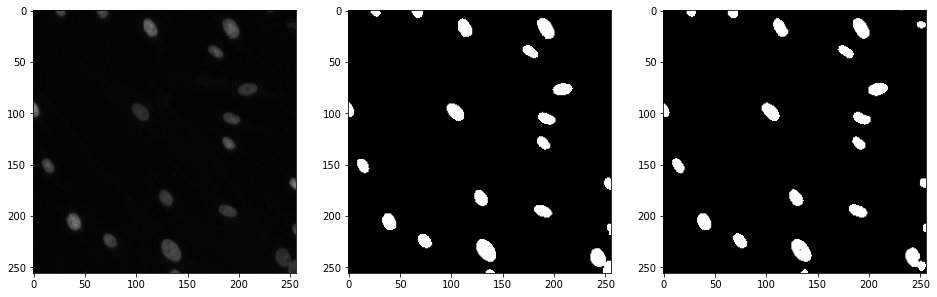

In [ ]:
index = 6

with torch.no_grad():
    #push a test datapoint through the model. Remember the raw outputs are called the logits!
    logits = segmentation_model(test_split[index][0].unsqueeze(0).to(device))[0].cpu()
    #apply $\sigma$ to the logits to make predictions and then apply a threshold to get a prediction mask
    pred = torch.sigmoid(logits) >= 0.5

#Plot the input, ground truth, and prediction
plt.figure(figsize=(16,10))
plt.subplot(1, 3, 1)
plt.imshow(test_split[index][0].permute(1,2,0).numpy(), cmap='gray')
plt.subplot(1, 3, 2)
plt.imshow(test_split[index][1].numpy()[0,:], cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(pred.numpy()[0,:], cmap='gray')

Overall the results are very good! We even get most of the literal edge cases correct. Objects that occur on the edges of images are often the harder to predict correctly.  Though there are some errors. For the really big nuclei, our segmentation model put a hole in it that does not belong there! We also detected some nuclei that don't actually exist. 

Part of this may be because our receptive field for the network is too small to accurately handle large nuclei. For each layer of convolution, the _maximal_ range is increased by $\left\lceil\frac{k}{2}\right\rceil$. Since we have 6 convolutional layers, that gets us just barley $2\cdot6=12$ pixels of width. While the simple option would be to add more layers or increase the width of the convolutions, those can get expensive. Part of why its so expensive is because we are never doing any pooling, so each time we add a layer or double the number of filters we are adding a big increase to the total memory used by our approach. 



## Transposed Convolutions

What we would prefer to do is to somehow use pooling so that we get the benefits of a smaller output (less memory) and larger receptive field, and then later _expand back up_ to a larger form. We can do this with what is called a _transposed_ convolution. In a normal convolution, _one output_ has it's value determined by _multiple inputs_. Because each output has multiple inputs, the output is _smaller_ than the input so that each output gets it's full contribution. An easy way to think about transposed convolutions is to imagine  _one input_ contributes to _multiple outputs_! Because the transposed version has one input to multiple outputs, we need to make the output _larger than the original input_ so that each output that an input contributes to is represented! The below image shows and example of convolution on top and transposed convolution on bottom. Both are using the same image and filter, applying it in their respective patterns. 


![Example of a regular convolution (top) and transposed convolution (bottom) when applied to the same input image with the same filter. The regular convolution shrinks the output by the size of the filter, and the transposed version extends the output by the size of the kernel.](https://drive.google.com/uc?export=view&id=1mLXgWDtpaNMbSI-VEslvIQsWz8qNZhZQ)

Just like a normal convolution the transposed version is adding all of the contributions at each location together to reach a final value. For this reason you will notice that the _inside_ area shown with a red dashed border has an _identical_ result between normal and transposed convolution. The difference is how we interpret border cases: regular convolution shrinks, transposed convolutions expand. In fact, every transposed convolution has an equivalent regular convoltion that has simply changed the amount of padding and other parameters applied! 

The important thing to remember here is that transposed convolutions give us a way to expand back up in size! In particular we can add a _stride_ to cause a doubling effect to reverse the halving effect caused by pooling. A _stride_ is how much we slide our filter by when applying a convolution. By default we use a stride $s=1$, meaning we slide the filter over one position at a time. The below figure shows what happens when we use a stride $s=2$. A regular convolution takes steps of 2 on the _input_, while a transposed one takes steps of 2 on the _output_. So a stride 2 _convolution will halve the size_ and a stride 2 _transposed convolution will double the size_. 

![Example on how a stride of $s=2$ impacts a regular and transposed convolution. The shaded regions show the input/output mappings. For convolution the input moves the filter by two positions, making the output smaller. Transposed convolution still uses every input position, but the output is moved by two positions. ](https://drive.google.com/uc?export=view&id=1SwUc3gsoOBfA7NhGp1ffxT1PbEAIFE2l)

The way we incorporate transposed convolution into our architecture is that, every few layers, we would do a round of pooling. If we do pooling in a 2x2 grid (the standard), we double the width of the model's receptive field! Each time we perform pooling, we end up looking at a "higher level" view of the image. Once we reach half-way through the network, we start to perform transposed convolutions to get back up to the correct size. The layers after transposed convolutions give the model a chance to "refine" the high level view. Similar to how we designed our auto-encoders from the last chapter, we will make the pooling and transpose rounds symmetric. 

Lets try it out and see what happens! In the interest of keeping these examples small and allowing them to run quickly, we will only do one round of pooling and transposed convolution. But if you did more, you might start to see better results! The below code re-defines our network with one round of max pooling and later one round of transposed convolution. 

In [ ]:
# set_seed(43)

In [ ]:
segmentation_model2 = nn.Sequential(
    nn.Conv2d(C, n_filters, (3,3), padding=1),  #Shape is (#filters, W, H) now
    nn.BatchNorm2d(n_filters),
    nn.LeakyReLU(),
    nn.Conv2d(n_filters, n_filters, (3,3), padding=1), 
    nn.BatchNorm2d(n_filters),
    nn.LeakyReLU(),
    nn.MaxPool2d(2), #Shrinks the height and width by 2
    nn.Conv2d(n_filters, 2*n_filters, (3,3), padding=1), 
    nn.BatchNorm2d(2*n_filters),
    nn.Conv2d(2*n_filters, 2*n_filters, (3,3), padding=1), 
    nn.BatchNorm2d(2*n_filters),
    nn.LeakyReLU(),
    nn.Conv2d(2*n_filters, 2*n_filters, (3,3), padding=1), 
    nn.BatchNorm2d(2*n_filters),
    nn.LeakyReLU(),
    #Double the height and width! 
    nn.ConvTranspose2d(2*n_filters, n_filters, (3,3), padding=1, output_padding=1, stride=2),
    nn.BatchNorm2d(n_filters),
    nn.LeakyReLU(),
    #Back to normal convolutions!
    nn.Conv2d(n_filters, n_filters, (3,3), padding=1), 
    nn.BatchNorm2d(n_filters),
    #Prediction for _every_ location
    nn.Conv2d(n_filters, 1, (3,3), padding=1), #Shape is now (B, 1, W, H)
)

In [ ]:
seg_results2 = train_network(segmentation_model2, loss_func, train_seg_loader, epochs=10, device=device, val_loader=test_seg_loader)

Now that we have trained this new model, lets try it on the same data and see what happens!

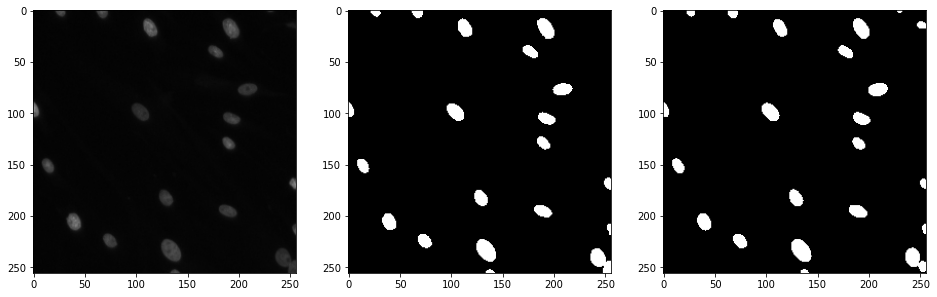

In [ ]:
index = 6

with torch.no_grad():
    pred = segmentation_model2(test_split[index][0].unsqueeze(0).to(device))[0].cpu()
    pred = torch.sigmoid(pred) >= 0.5

    
plt.figure(figsize=(16,10))
plt.subplot(1, 3, 1)
plt.imshow(test_split[index][0].permute(1,2,0).numpy(), cmap='gray')
plt.subplot(1, 3, 2)
plt.imshow(test_split[index][1].numpy()[0,:], cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(pred.numpy()[0,:], cmap='gray')

In [ ]:
del segmentation_model
del segmentation_model2

The hole has been patched! You may also notice the network has done a slightly better job with some of the edge cases. Working on a smaller representation (the rounds after pooling) helps to encourage softer and smoother masks in our output. But we should never look at just a single image to decide if we've made an improvement, so lets look at the validation loss. 

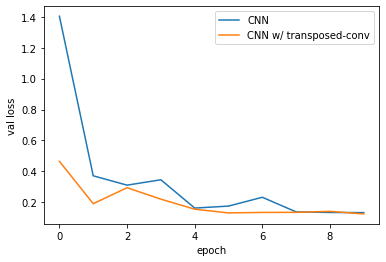

In [ ]:
sns.lineplot(x='epoch', y='val loss', data=seg_results, label='CNN')
sns.lineplot(x='epoch', y='val loss', data=seg_results2, label='CNN w/ transposed-conv')

According the to validation error, we have overall done a _slightly_ better job than before. Something that is often just as important is learning speed, and we can see this approach was able to make faster progress in fewer epochs of training. This faster learning is a  big benefit, and it's importance only grows as we work on harder and larger problems! 

# U-Net

Right now we have two ways to model the image segmentation problem. One involves using rounds of max-pooling followed by transposed convolutions later. You can think of this approach as progressively looking at higher level regions of the image. The more rounds of pooling you do the higher level the model looks to make decisions. The first approach used no pooling and just many rounds of convolution. This makes a model that can look at minute and fine-grained details. The max pooling/up-sampling will work well for detecting larger objects and broad borders and the fine-grained model will work better for small objects and nuanced boarders of an object. But is there a way we could get the best of both worlds? 

We can achieve this by including _skip connections_ from Chapter 6 into our approach! This ends up creating an architecture approach known as _U-Net_, which is shown in the below diagram. 

![Example of a U-Net style architecture. After some rounds of convolution, max pooling is used to shrink the image several times. Eventually transposed convolution up-samples the results, and every up-sample includes a skip connection to the previous result before pooling. The results are concatenated together and proceed to a new output round of convolutions. The architecture makes a "U" like shape. ](https://drive.google.com/uc?export=view&id=1spiaAxScep3hh0yxBcHaI0Sxzc3N-BvH)

Every round of max pooling involves doubling the number of filters, and every round of transposed convolution to increase the resolution halves the number of filters. This up-sampling is concatenated with the result _before_ pooling occurred. This way the subsequent layers have a fine-grained view of the data _before pooling_ and a higher level view _after pooling_. When you draw out the architecture in a diagram you end up with a "U" like shape, hence the name "U-Net". 

The above diagram shows one group of Conv2d, BatchNorm, and ReLu activation per input/output pair - but you could have any number of hidden layer blocks as you like. While U-Net refers to both a _specific_ architecture and a _style_ of architecture, and I'm going to refer to the style over all. Below well define some code for implementing U-Net style models. 

To make our implementation simpler we will take in the number of `in_channels` and use `mid_channels` as how many filters should be used in the convolutions. If we want the output to have a different number of channels, we will use a 1x1 convolution to change `mid_channels` to `out_channels`. We will also use a `sub_network` to represent the model that is applied on the shrunk version of the image after `nn.MaxPol2d` is applied. If we make the `sub_network` another U-Net block, we can build up a full U-Net model. The code is going to assume that the `sub_network` outputs `mid_channels` as the number of channels so that when we concatenate the skip-connection and the `sub_network` output, that we end up with exactly `2*mid_channels`. 

In [ ]:
class UNetBlock2d(nn.Module): #Our class extends nn.Module, all PyTorch layers must extend this! 
    def __init__(self, in_channels, mid_channels, out_channels=None, layers=1, sub_network=None, filter_size=3):
        """ 
        in_channels: the number of channels in the input to this block
        mid_channels: the number of channels to have as the output for each convolutional filter
        out_channels: if not `None`, ends the network with a 1x1 convolution to convert the number of output channels to a specific number. 
        layers: how many blocks of hidden layers to create on both the input and output side of a U-Net block
        sub_network: the network to apply after shrinking the input by a factor of 2 using max pooling. The number of output channels should be equal to `mid_channels`
        filter_size: how large the convolutional filters should be
        """
        super().__init__()
        
        #Start preparing the layers used to process the input
        in_layers = [
            nn.Conv2d(in_channels, mid_channels, filter_size, padding=filter_size//2), 
            nn.BatchNorm2d(mid_channels),
            nn.LeakyReLU(),
        ]
        
        #If we have a sub-network, we will double the number of inputs to the output. So lets figure that out now
        if sub_network is None:
            inputs_to_outputs = 1
        else:
            inputs_to_outputs = 2

        #Preparing the layers used to make the final output, which has extra input channels from any sub-network
        out_layers = [
            nn.Conv2d(mid_channels*inputs_to_outputs, mid_channels, filter_size, padding=filter_size//2), 
            nn.BatchNorm2d(mid_channels),
            nn.LeakyReLU(),
        ]
        
        #Collect the additional layers used for the input and output
        for _ in range(layers-1):
            in_layers.append( nn.Sequential(
                nn.Conv2d(mid_channels, mid_channels, filter_size, padding=filter_size//2), 
                nn.BatchNorm2d(mid_channels),
                nn.LeakyReLU(),
            ))
            out_layers.append( nn.Sequential(
                nn.Conv2d(mid_channels, mid_channels, filter_size, padding=filter_size//2), 
                nn.BatchNorm2d(mid_channels),
                nn.LeakyReLU(),
            ))
        #Use 1x1 Convolutions to ensure a specific output size
        if out_channels is not None:
            out_layers.append(nn.Conv2d(mid_channels, out_channels, 1, padding=0))
    
        #define our three total networks.
        #in_model performs the intial rounds of convolution
        self.in_model = nn.Sequential(*in_layers)
        #our subnetwork works on the max-pooled result. We will add the pooling and up-scaling directly into the sub-model
        if sub_network is not None:
            self.bottleneck = nn.Sequential(
                nn.MaxPool2d(2), #Shrink
                sub_network, #process the smaller resolution
                #expand back up
                nn.ConvTranspose2d(mid_channels, mid_channels, filter_size, padding=filter_size//2, output_padding=1, stride=2)
            )
        else:
            self.bottleneck = None
        #the output model that processes the concatinated result, or just the output from in_model if no sub-network was given
        self.out_model = nn.Sequential(*out_layers)
        
    
    #The forward function is the code that takes an input and produce an output. 
    def forward(self, x):
        #compute the convolutions at the current scale
        full_scale_result = self.in_model(x) #(B, C, W, H)
        #check if we have a bottleneck to apply
        if self.bottleneck is not None:
            #(B, C, W, H) shape because bottleneck does both the pooling & expansion
            bottle_result = self.bottleneck(full_scale_result)
            #Now shape (B, 2*C, W, H)
            full_scale_result = torch.cat([full_scale_result, bottle_result], dim=1)
        #compute the output on the concatinated (or not!) result
        return self.out_model(full_scale_result)

Now with this one `UNetBlock2d` module we can implement an entire U-Net architecture by specifying that the `sub_network` itself be another `UNetBlock2d`. We can then just repeat this as many times as we like. The below code shows that in action, nesting 3 `UNetBlock2d`s together, followed by one round of convolution to reach our desired output size. 

In [ ]:
unet_model = nn.Sequential(
    UNetBlock2d(3, 32, layers=2, sub_network=
        UNetBlock2d(32, 64, out_channels=32, layers=2, sub_network=
            UNetBlock2d(64, 128, out_channels=64, layers=2)
        ),
    ),
    #Prediction for _every_ location
    nn.Conv2d(32, 1, (3,3), padding=1), #Shape is now (B, 1, W, H)
)

Next we train this model, and plot the results in comparison to our first two segmentation models. You'll notice that the U-Net approach is a best of both worlds, giving us both lower total loss and learning faster than either the fine or course grained models from before! 

In [ ]:
unet_results = train_network(unet_model, loss_func, train_seg_loader, epochs=10, device=device, val_loader=test_seg_loader)

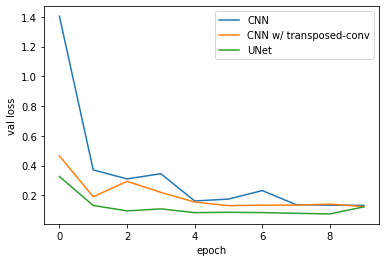

In [ ]:
sns.lineplot(x='epoch', y='val loss', data=seg_results, label='CNN')
sns.lineplot(x='epoch', y='val loss', data=seg_results2, label='CNN w/ transposed-conv')
sns.lineplot(x='epoch', y='val loss', data=unet_results, label='UNet')

The U-Net approach is a strong starting point for any image segmentation problem, or any related tasks where you may need to make a prediction about multiple points within an image. It is also a repetition of some similar concepts we have already learned: combining skip-connections, 1x1 convolutions allow us to build a more expressive  and powerful model. This also shows how we can adjust these concepts to apply certain kinds of priors to the data we are working on. We had the belief that we want small local details and courser higher level details in order to make a better decisions, and we used skip connections and transposed convolution to embed that prior into the very design of our architecture! Learning to recognize these opportunities and following through on them will make the biggest difference in your results compared to almost anything else you might do. 

# Object Detection with Bounding Boxes

Now that we have learned about object segmentation, we will extend the approach to build a more complete object detection framework. In particular, we are going to go over an algorithm called _Faster R-CNN_, which has become the defacto baseline for object detection. Most other approaches you may learn about are variations on the Faster R-CNN. Like most object detectors Faster R-CNN uses the idea of _bounding boxes_ for labels and prediction. The below figure shows a potential bounding box label and prediction for a stop sign. The bounding box approach is often preferred because it is cheaper and easier to label. You simply need some software to annotate a box around an image (you can find some freely available [online](https://github.com/heartexlabs/awesome-data-labeling#images)), which is much easier then painstakingly marking _every pixel_ as required by image segmentation. 

![A stop sign as the target for a bounding-box based object detection. The green box shows the ground-truth, a box _just_ large enough to contain the entire object. The red box shows a potential prediction, which is close but not quite correct. ](https://drive.google.com/uc?export=view&id=1aKs7RlbbK__xMvsHhOvi3l5oc-2w14N0)

We want to detect objects by drawing a box around any object of interest. Since objects could be at weird sizes or angles, the goal is that the box should "bound" the object, so the box should be _just_ big enough to fit the entire object within the box. We do not want the box to be any larger, because then one could "cheat" by just marking a box the size of the image! We also don't want the box to be any smaller, because then it will miss part of the object, and we don't want a single object to have multiple boxes!

The image below gives an overview of the Faster R-CNN algorithm. It is a complicated algorithm with many parts, but by this point you've learned enough to understand all the parts that make the whole. In particular, Faster R-CNN can be broken up into three sub-networks, a _Backbone network_ to extract feature maps, a _Region Proposal Network_ (RPN) to find objects, and a _Region  of Interest Pooling_ (RoI Pooling or just RoI) network that predicts what type of object is being looked at. Faster R-CNN is an extension of what we have learned because the backbone network is a fully convolutional network like we used for image segmentation, except we have the final convolution layer output some number of $C'$ channels instead of just 1 channel. 

![Diagram of a Faster R-CNN being applied to the stop sign from before. The backbone network scans the image and is the largest network, doing the "heavy lifting" to produce good features for the rest of the algorithm. The Region Proposal Network comes next and is also fully-convolutional but very small. It re-uses the work of the backbone's feature map to make predictions or "proposals" for where objects _may_ be in the image. Finally a Region of Interest network takes every sub-region of the feature map that corresponds to one of the proposals, and makes a final determination on whether an object is present -and if so - what object it is. ](https://drive.google.com/uc?export=view&id=1ZbF69ykYr7sjph0Hph9yoxntSFuYvoEI "Faster R-CNN")

We are not going to implement Faster R-CNN from scratch because it has a number of important nuance details and takes hundreds of lines of code to implement in total. But we are going to review all the critical components of Faster R-CNN because so many other object detectors build upon this approach. Faster R-CNN is also built into PyTorch, so you don't have to do so much work to leverage it yourself! Below we will summarize how each sub-network works in the order that they are used. 


## Backbone 

The backbone network is essentially _any_ neural network that works like the object segmentation network we just defined! It takes in a image with a width, height, and some number of channels $(C, W, H)$, and outputs a new feature map $(C', W', H')$. The Backbone can have a different width and height, so long as it is consistent (i.e., $W'=W\cdot z$ is _ok_ for any $z \in (0, 1]$). 

The goal of the Backbone is to _do all of the feature extraction_, so that the other sub-networks can be smaller and don't need to be very complex. This makes it faster to run (only one big network to run once) and helps coordinate the two other sub-networks (they are working from the same representation).

## Region Proposal Network

Once the backbone has given us a feature-rich representation of our image as a $(C', W', H')$ tensor, the RPN network has the job of determining if an object exists at a specific location in the image. It does this by predicting two things:

1) A bounding box with 4 locations (top left, top right, bottom left, and bottom right)
2) A binary prediction to classify the box as "has object" and "does not have object"

In this case it does not matter how many classes we are trying to predict, or what specific object is present --- the only goal is to determine if an object exists and where the object is. Essentially, all the classes of your problem are merged into one "super class" of "has object". 

To make the model even more robust, we can actually do these 6 total predictions (4 box coordinates + 2 object/no object) $k$ times. The idea here is to give the model $k$ chances to predict the correct box shape during learning. A common default is to use $k=9$ guesses. This allows the RPN to have multiple predictions about the size or shape of an object at a given location within the image, and is a common optimization that is included in most implementations. 

Because we are making $k$ predictions per location, we _know_ that there will be more false positives than necessary. This is part of why the predictions are called _proposals_ instead of "predictions". We expect that many more proposals will exist than actual objects, and later in the process we will do more work to clean up these false positives. 

The RPN _could_ be implemented with a single convolutional layer, using `nn.Conv2d(C', 6*k, (1,1))`, which would slide over ever location in the image and make 6 predictions. This is a trick to use a one-by-one convolution to make local predictions. In real implementations this is usually done with two layers instead, so something like:

```
nn.Sequential(
    nn.Conv2d(C', 256, (1,1)),  #One layer for non-linearities
    nn.BatchNorm2d(256),
    nn.LeakyReLU(),
    nn.Conv2d(256, 6*k, (1,1)),
    #Seperate out into 4,2 for box and classification
)
```

Adding just one extra layer gives the model some non-linear capability to do better prediction. We are able to use such a small network because the Backbone network has already done the heavy lifting! So a small, fast, barely non-linear RPN network runs on top of the backbone. The RPN's job is to make predictions about _where_ objects are and _what their shape is_. 

## RoI Pooling

The last step is called RoI pooling. The outputs of the RPN give us the locations for $W' \cdot H' \cdot k$ total potential regions of interest. But each of these regions may be a different size and overlap with each other! At training we need to make predictions for all of these regions so that the model can learn to suppress false positives and detect false negatives. At test time we only need to make predictions for the proposals that received larger scores from the RPN sub-network. In both training and testing, we have an issue that the _size of the proposals is variable_. So we need to devise a network that can handle _variable sized_ inputs and still make a single prediction. 

To achieve this, we use _adaptive pooling_. In normal pooling we say how much we want to shrink the input by (e.g., we usually shrink the image by a factor of 2). In adaptive pooling, we state how large we want the output to be, and adaptive pooling adjusts  the shrinkage factor based on the input's size. For example, if we want a 3x3 output, and the input is 6x6, adaptive pooling would be done in a 2x2 grid ($6/2=3$). But if the input was 12x12, the pooling would be done in as 4x4 grid to get $12/4=3$. That way we _always_ get the same size output! 

The code for this sub-network might look something like:

```
nn.Sequential(
    nn.AdaptiveMaxPool2d((7,7)),
    nn.Flatten(),
    nn.Linear(7*7, 256),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(),
    nn.Linear(256, classes),
)
```

The RoI network starts with adaptive pooling to enforce a particular size for all predictions. This is an aggressively small $7\times7$ in order to make the RoI network small and fast to run since we will have many proposals to process. It is so small we follow it with just two rounds of `nn.Linear` layers instead of convolutional ones because its been shrunk so much! We can then apply this network to every region identified by the RPN network, regardless of the size, and get a prediction. 

## Faster R-CNN in PyTorch

Now, the details and minutea of implementing Faster R-CNN are not trivial, and its a tough algorithm to get all the details right for. If you want all the details, check out [this website](http://www.telesens.co/2018/03/11/object-detection-and-classification-using-r-cnns/). Lucky for you, PyTorch has Faster R-CNN built in! Training it is expensive though, so we are going to create a toy problem from MNIST to show the basics of using it. 

Out toy dataset will be a larger 100x100 image, with a random number of MNIST digits in random locations in the image. The goal will be to detect where these images are, and classify them correctly. Our dataset will return a tuple. The first item in the tuple is the 100x100 image we want to perform object detection on. The second item in the tuple is a dictionary with two sub-tensors. 

The first sub-tensor will be indexed by the name "boxes". If there are $k$ objects in the image, this will have a shape of $(k, 4)$ and store `float32` values giving the four corners of the box. The second item will be indexed by "labels", and is only necessary if we want to perform training. This tensor looks more like the ones we have used before, with a shape of $(k)$ `int64` values giving the class ID for each of the $k$ objects to be detected. 

The below code block shows our `Dataset` class that implements all of this for our toy MNIST detector. Note the comments for computing the `offset`, as the bounding box corners are all  absolute locations, so we need to compute two of the corners based on their relative distance to the starting corners. 

In [ ]:
set_seed(42)

In [ ]:
class Class2Detect(Dataset):
    """This class is used to create a simple converstion of a dataset from a classification problem, 
    to a detection problem. """

    def __init__(self, dataset, toSample=3, canvas_size=100):
        """
        dataset: the source dataset to sample items from as the "objects" to detect
        toSample: the maximum number of "objects" to put into any image
        canvas_size: the width and height of the images to place objects inside of. 
        """
        self.dataset = dataset
        self.toSample = toSample
        self.canvas_size = canvas_size

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        
        boxes = []
        labels = []
        
        final_size = self.canvas_size
        #First, create a larger image that will store all the "objects" to detect
        img_p = torch.zeros((final_size,final_size), dtype=torch.float32)
        #Now we are going to sample up to self.toSample objects to place into the image
        for _ in range(np.random.randint(1,self.toSample+1)):
            
            #Pick an object at random from the original dataset, and its label
            img, label = self.dataset[np.random.randint(0,len(self.dataset))]
            #Get the height and width of that image
            _, img_h, img_w = img.shape
            #Pick a random offset of the x and y axis, essentially placing the image at a random location
            offsets = np.random.randint(0,final_size-np.max(img.shape),size=(4))
            #Change the padding at the end to make sure we come out to a specific 100,100 shape
            offsets[1] = final_size - img.shape[1] - offsets[0]
            offsets[3] = final_size - img.shape[2] - offsets[2]
            
            with torch.no_grad():
                img_p = img_p + F.pad(img, tuple(offsets))
            #Lets craete the values for the "boxes"
            #all of these are in absolute pixel locations
            
            #x_min determined by the randomly selected offset
            xmin = offsets[0]
            #x_max is the offset plus the image's width
            xmax = offsets[0]+img_w
            #y min/max follows the same pattern
            ymin = offsets[2]
            ymax = offsets[2]+img_h
            #now we add to the box with the right label
            boxes.append( [xmin, ymin, xmax, ymax] )
            labels.append( label )

            
        target = {}
        target["boxes"] = torch.as_tensor(boxes, dtype=torch.float32)
        target["labels"] = torch.as_tensor(labels, dtype=torch.int64)
        
        return img_p, target

The Faster R-CNN implementation of PyTorch does not take input batches using the pattern we have used thus far (one tensor with everything padded to be the same size). The reason for this is because Faster R-CNN is designed to work with images of highly variable size, so we would not have the same $W$ and $H$ values for every item! Instead Faster R-CNN wants a `list` of tensors, and a `list` of dictionaries. We will have to use a custom collate function to make that happen. The below code creates our training and test set, along with the needed collate function and loader. 

In [ ]:
train_data = Class2Detect(torchvision.datasets.MNIST("./", train=True, transform=transforms.ToTensor(), download=True))
test_data = Class2Detect(torchvision.datasets.MNIST("./", train=False, transform=transforms.ToTensor(), download=True))

def collate_fn(batch):
    """
    batch is going to contain a python list of objects. In our case, our data loader returns (Tensor, Dict) pairs
    The FasterRCNN algorithm wants a List[Tensors] and a List[Dict]. So we will use this function to convert the 
    batch of data into the form we want, and then give it to the Dataloader to use
    """
    imgs = []
    labels = []
    for img, label in batch:
        imgs.append(img)
        labels.append(label)
    return imgs, labels

train_loader = DataLoader(train_data, batch_size=128, shuffle=True, collate_fn=collate_fn)
# test_loader = DataLoader(test_data_xx, batch_size=128)

Now we have all our data set up! Lets look at some of our data first just to get a sense of it. 

In [ ]:
x, y = train_data[0] # Grab an image with its labels

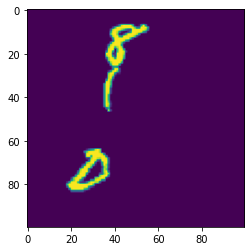

In [ ]:
imshow(x.numpy()[0,:])

We can see the above image has three items in random locations! In this case an 8, 1, and 0. Lets look at the label object "y". Its a python `dict` object so we can see the keys and values, and index the `dict` to look at the individual items it contains. 

In [ ]:
y #prints out everything

{'boxes': tensor([[14., 60., 42., 88.],
         [23., 21., 51., 49.],
         [29.,  1., 57., 29.]]),
 'labels': tensor([0, 1, 8])}

In [ ]:
y['boxes'] #prints a tensor showing the pixel locations of the corners for all 3 objects

tensor([[14., 60., 42., 88.],
        [23., 21., 51., 49.],
        [29.,  1., 57., 29.]])

In [ ]:
y['labels'] #prints a tensor showing the labels for all 3 objects

tensor([0, 1, 8])

Looks sensible! We can see the "boxes" component of y has shape $(3,4)$, and the "labes" has shape $(3)$. If we compare the first row of "boxes" with the image above, we can see that on the x-axis it starts around 30 and goes out near 60, which corresponds to the values in the "boxes" tensor! You can see the same holds for the height values (y coordinates), starting near 10 and going down near 30. 

The important thing here is that the boxes and the labels occur in a consistent order. Label 4 could be the first label so long as the first row of "boxes" has the correct location of the object 4! 

With this in place, lets build a small backbone network to use! We will simply iterate a number of "Conv, BatchNorm, ReLU" in blocks, and slowly increase the number of filters. The last thing we need to do is just add a `backbone.out_channels` value to the network we create. This tells the Faster R-CNN implementation the value of $C'$ which is the number of channels in the feature map produced by the backbone network. This is used to set up the RPN and RoI sub-networks for us. Both the RPN and RoI networks are so small there aren't a lot of parameters for us to tune, and we don't want to make them bigger because it will make the training and inference very expensive. 

In [ ]:
#How many channels are in the input?
C = 1
#How many classes are there?
classes = 10
#How many filters in our backbone
n_filters = 32

In [ ]:
backbone = nn.Sequential(
    nn.Conv2d(C, n_filters, (3,3), padding=1), 
    nn.BatchNorm2d(n_filters),
    nn.LeakyReLU(),
    nn.Conv2d(n_filters, n_filters, (3,3), padding=1), 
    nn.BatchNorm2d(n_filters),
    nn.LeakyReLU(),
    nn.Conv2d(n_filters, n_filters, (3,3), padding=1), 
    nn.BatchNorm2d(n_filters),
    nn.MaxPool2d((2,2)),
    nn.LeakyReLU(),
    nn.Conv2d(n_filters, 2*n_filters, (3,3), padding=1),
    nn.BatchNorm2d(2*n_filters), 
    nn.LeakyReLU(),
    nn.Conv2d(2*n_filters, 2*n_filters, (3,3), padding=1), 
    nn.BatchNorm2d(2*n_filters),
    nn.LeakyReLU(),
    nn.Conv2d(2*n_filters, 2*n_filters, (3,3), padding=1), 
    nn.MaxPool2d((2,2)),
    nn.BatchNorm2d(2*n_filters),
    nn.LeakyReLU(),
    nn.Conv2d(2*n_filters, 4*n_filters, (3,3), padding=1), 
    nn.BatchNorm2d(4*n_filters),
    nn.LeakyReLU(),
    nn.Conv2d(4*n_filters, 4*n_filters, (3,3), padding=1), 
    nn.BatchNorm2d(4*n_filters),
    nn.LeakyReLU(),
)

backbone.out_channels = n_filters*4

Now we can define our Faster R-CNN model! We give it the backbone network, tell it how many clases exist, and how to normalize the image (if your images values are in the range of $[0,1]$, a mean of 0.5 and deviation of 0.23 are good defaults for most images). We also tell Faster R-CNN in the minimum and maximum image sizes. To make this run faster, we are setting them both to the only image size of 100. But for real data, this is used to try and detect objects at multiple scales. That way it can handle objects that are up-close or far away. But this requires more computaion to run and even more still to train! 

How should you set the min and max size for Faster RCNN on real problems? A familiar rule of thumb: if its too small for a human to do it, the network probably can't do it either. Take your data and try looking for the objects you care about at different image resolutions. If the smallest you can find your object at is $256 \times 256$ , thats a good minimum size. If the largest you need to make your images to spot the objects is $1024 \times 1024$, then that is a good max size!

In [ ]:
model = FasterRCNN(backbone, num_classes=10, image_mean = [0.5], image_std = [0.229], min_size=100, max_size=100)

Because of the unusual use of lists of tensors and lists of dictionaries, we can't use our standard `train_network` function to handle this case for us. So we will write a minimal training loop to go through and do that training for us (I promise this is the only time this will happen!). The main "trick" here is to move every item within each list (inputs and labels) to the compute device we want to use. This is because the `.to(device)` method only exists for PyTorch `nn.Module` classes, and the standard list and dictionary in python don't have these functions. Luckily we defined a `moveTo` function early on that does this and works on lists and dictionaries. 

The second oddity is that the Faster RCNN object behaves different when in training mode and evaluation model. In training mode it expects the labels to be passed in with the inputs so that it can compute the loss of every prediction. It will also return a list of every individual prediction loss instead of a single scalar! So we need to add all of these individual losses to get a final total loss. The below code shows a simple loop for training just 1 epoch of Faster RCNN. 

In [ ]:
model = model.train()
model.to(device)
optimizer = torch.optim.AdamW(model.parameters())

for epoch in tqdm(range(1), desc="Epoch", disable=False):
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc="Train Batch", leave=False, disable=False):
        #Move the batch to the device we are using. 
        inputs = moveTo(inputs, device)
        labels = moveTo(labels, device)

        optimizer.zero_grad()
        #rcnn wants model(inputs, labels) - not just model(inputs)
        losses = model(inputs, labels)
        # Compute loss, RCNN gives us a list of losses to add up.
        loss = 0
        for partial_loss in losses.values():
            loss += partial_loss
        #now proceed like normal!
        loss.backward()
        
        optimizer.step()

        running_loss += loss.item()

/home/eman7613/anaconda3/lib/python3.7/site-packages/torchvision/ops/boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629427478/work/torch/csrc/utils/python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)


Thats all it took for us to use the Faster R-CNN implementation provided by PyTorch! Now lets see how well it did. First I'm going to set the model to `eval` mode which is going to change how the Faster R-CNN implementation takes inputs and returns outputs. 

In [ ]:
model = model.eval()
model = model.to(device)

In [ ]:
set_seed(161)

Now lets quickly grab an item from the test dataset and see what it looks like. In this case we see it has three objects, an 8, 0, and 4. 

In [ ]:
x, y = test_data[0]

In [ ]:
y #this is the ideal truth we want to get back

{'boxes': tensor([[31., 65., 59., 93.],
         [10., 36., 38., 64.],
         [64., 24., 92., 52.]]),
 'labels': tensor([8, 0, 4])}

Now lets make a prediction. Since we are in `eval` mode, PyTorch wants a `list` of images to make predictions on. It also no longer needs a `labels` object to be passed in as a second argument, which is good because if we already knew where all the objects were we wouldn't be doing this! 

In [ ]:
with torch.no_grad():
    pred = model([x.to(device)])

And now we can look at our results. PyTorch's implementation returns a `list` of  `dict`s with three items in it: "boxes" for the locations of predicted items, "labels" for the class predicted for each item, and "scores" for a confidence associated with each prediction. The below code shows the content of `pred` for this image. 

In [ ]:
pred

[{'boxes': tensor([[65.0383, 24.6431, 93.2958, 52.4429],
          [31.1959, 64.8449, 60.4037, 93.6265],
          [31.1136, 64.5596, 60.4278, 93.9368],
          [65.8958, 26.4852, 94.1073, 52.0305],
          [31.5456, 64.3395, 59.5109, 94.2821]], device='cuda:0'),
  'labels': tensor([4, 8, 6, 9, 9], device='cuda:0'),
  'scores': tensor([0.9732, 0.9163, 0.2891, 0.0854, 0.0587], device='cuda:0')}]

We see that each dictionary has a "boxes" tensor with $(k', 4)$ shape for $k'$ predictions. The "labels" tensor has $(k')$ shape giving the label it predicted for each object. Last, the "scores" tensor also has $(k')$ shape, and returns a score in the range of $[0, 1]$ for each returned prediction. These scores are the "object" scores from the RPN sub-network. 

In this case the model is confident it found and 8 and a 4 ($\geq 0.9$ scores), but less confident some other classes. Its easier to understand these results by printing them into a picture, so well quickly define a function to do that for us. 

In [ ]:
import matplotlib.patches as patches

In [ ]:
def plotDetection(ax, abs_pos, label=None):
    """
    ax: the matpllib axis to add this plot to
    abs_pos: the positions of the bounding box
    label: the label of the prediction to add
    """
    x1, y1, x2, y2 = abs_pos
    #make a rectangle for the bounding box
    rect = patches.Rectangle((x1,y1),x2-x1,y2-y1,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    #add the label if given
    if label is not None:
        plt.text(x1+0.5, y1, label, color='black', bbox=dict(facecolor='white', edgecolor='white', pad=1.0))
    
    return 

def showPreds(img, pred):
    """
    img: the image to show the bounding box predictions for
    pred: the Faster R-CNN predictions to show ontop of the image
    """
    fig,ax = plt.subplots(1)
    #plot the image
    ax.imshow(img.cpu().numpy()[0,:])
    #grab the predictions
    boxes = pred['boxes'].cpu()
    labels = pred['labels'].cpu()
    scores = pred['scores'].cpu()
    
    num_preds = labels.shape[0]
    #for each prediction, plot if if it has a high enough score
    for i in range(num_preds):
        plotDetection(ax, boxes[i].cpu().numpy(), label=str(labels[i].item()))
    
    plt.show()

With this code in hand, we use it below to plot the result of Faster R-CNN on this image. Now we can clearly see that the network did indeed do a good job on the 4 and 8, but completely missed the 0! We also have these spurious other predictions from the network identifying sub-parts of the 4 and 8 as other digits! For example, look at the right half of the 4. If you weren't paying attention to the left half of it, you might say it was the digit 1 - or you could be looking at the whole image and think it's an incomplete 9.  The 8 has similar issues. If you ignore the loop in the top-left, it does look like a "6" was drawn, and if you ignore the right half of the 8, you could be forgiven for calling it a 9!

Spurious overlapping objects is a very common problem with object detectors. Sometimes these overlapping objects are predictions of the same object (e.g., identifying several eights), or mislabeled predictions like we see below. 

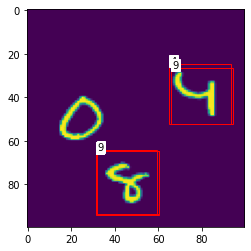

In [ ]:
showPreds(x, pred[0])

## Suppress overlapping boxes

A simple and effective solution to this problem is to _suppress_ overlapping boxes. How do we know which boxes to suppress? We want to make sure we pick the _correct_ box to use, but also don't want to throw away boxes that are correctly predicting an adjacent object! 

A simple approach called _non-maximum suppression_ (NMS) can be used to do this for us. NMS uses the _Intersection over Union_ (IoU) between two boxes to determine if they overlap _too_ much. The IoU is a score where 1 indicates the boxes are the same exact location, and 0 indicates that they have no overlap. A visual depiction of how it is computed is shown below. 

![Calculation of the Intersection over Union score is done by dividing the area of overlap between two boxes by the area of the union between two boxes. ](https://drive.google.com/uc?export=view&id=1n5E7McxuXxOUGyIj95g7bQv9lwOxRjtP)

IoU literally divides the size of the intersection of two boxes by the area of the two boxes. This way we get a size sensitive measure of how similar two box positions are. NMS works by taking every pair of boxes that have an IoU above some specified threshold, and keeping only the one with the _largest_ score from the RPN network. 

Lets quickly see how the NMS method works on our data. We can import it from pytorch as the `nms` function. 

In [ ]:
from torchvision.ops import nms

Lets quickly remind ourselves of the boxes we have and their associated scores by printing out these fields from the `pred` returned by our `model`. 

In [ ]:
pred[0]['boxes']

tensor([[65.0383, 24.6431, 93.2958, 52.4429],
        [31.1959, 64.8449, 60.4037, 93.6265],
        [31.1136, 64.5596, 60.4278, 93.9368],
        [65.8958, 26.4852, 94.1073, 52.0305],
        [31.5456, 64.3395, 59.5109, 94.2821]], device='cuda:0')

In [ ]:
pred[0]['scores']

tensor([0.9732, 0.9163, 0.2891, 0.0854, 0.0587], device='cuda:0')

The `nms` function will happily take the tensor of boxes as the first argument, and the tensor of scores as the second. The third and final argument is the threshold for calling two boxes different objects. So the below code is saying that if the IoU between two boxes if 50% or more, they are the same item and we should keep the box with the highest score.  

In [ ]:
nms(pred[0]['boxes'], pred[0]['scores'], 0.5)

tensor([0, 1], device='cuda:0')

We used a threshold of 50% overlap and `nms` then returns a tensor of an equal to or smaller size, telling us which indices should be kept. In this case, it says to keep boxes 0 and 1, which indeed had the highest scores!

So lets modify our predictions function to use the NMS to clean up the output from Faster R-CNN. We will also add a `min_score` flag which we can use to suppress predictions that are unlikely to be meaningful. 

In [ ]:
def showPreds(img, pred, iou_max_overlap=0.5, min_score=0.05, label_names=None):
    """
    img: the original image object detection was performed on
    pred: the output dictionary from FasterRCNN for evaluation on img
    iou_max_overlap: the iou threshold at which non-maximum suppression will be performed
    min_score: the minimum RPN network score to consider an object
    """
    fig,ax = plt.subplots(1)
    img = img.cpu().numpy()
    if img.shape[0] == 1:
        ax.imshow(img[0,:])
    else:
        ax.imshow(np.moveaxis(img, 0, 2))
    boxes = pred['boxes'].cpu()
    labels = pred['labels'].cpu()
    scores = pred['scores'].cpu()
    
    selected = nms(boxes, scores, iou_max_overlap).cpu().numpy()
    
    for i in selected:
        if scores[i].item() > min_score:
            if label_names is None:
                label = str(labels[i].item())
            else:
                label = label_names[labels[i].item()]
            plotDetection(ax, boxes[i].cpu().numpy(), label=label)
    
    plt.show()

Below we again plot this image using our improved `showPreds` function, and we see a better and cleaner result! Just the 4 and 8 on their own. Alas the 0 is still undetected, and there is nothing we can do to fix that besides more data and more epochs of training! 

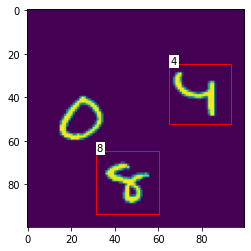

In [ ]:
showPreds(x, pred[0])

# Using the Pre-Trained Faster R-CNN

PyTorch also provides a pre-trained Faster R-CNN model for you to use. Its trained on a dataset called "COCO", and we can instantiate it and see the class names used for this model below. 

In [ ]:
rcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /home/eman7613/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


We will set this model into `eval` mode since it does not need training, and we will also define the below `NAME` list that contains the class names for all the objects that this pre-trained RCNN knows how to detect. 

In [ ]:
rcnn = rcnn.eval()

In [ ]:
# COCO_INSTANCE_CATEGORY_NAMES
NAME = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]


Lets try downloading some images from the Internet and seeing how well our model does! Keep in mind that random images contain lots of things this algorithm has _never_ seen before. This will help give you some ideas about both how you might be able to use a Faster R-CNN model in the future, but also interesting ways in which they can fail! The below code imports some libraries for grabbing images from a URL, as well as three URLs to some interesting images to try and detect objects in feel free to change which URL is used, or add your own URLs to try out the object detector on something different!

In [ ]:
from PIL import Image
import requests
from io import BytesIO

urls = [
    "https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/10best-cars-group-cropped-1542126037.jpg",
    "https://miro.medium.com/max/5686/1*ZqJFvYiS5GmLajfUfyzFQA.jpeg",
    "https://www.denverpost.com/wp-content/uploads/2018/03/virginia_umbc_001.jpg?w=910"
]

response = requests.get(urls[0])
img = Image.open(BytesIO(response.content))

Once we have loaded the image, we will re-format it into the way that PyTorch's pre-trained model wants. This includes normalizing the pixel values to the range $[0, 1]$ and re-ordering the dimensions to be channel, width, height. Thats done in the below code, followed by making our prediction!

In [ ]:
img = np.asarray(img)/256.0
img = torch.tensor(img, dtype=torch.float32).permute((2,0,1))

with torch.no_grad():
    pred = rcnn([img]) # Pass the image to the model

Now we can check out the results below! You may find that you need a different `nms` threshold or `min_score` for each image to get the best results. Tuning these parameters can be very problem dependent. It depends on the relative cost of false positives vs false negatives, the difference between the training images in style/content vs the testing images, and ultimately _how_ you will be using your object detector! 

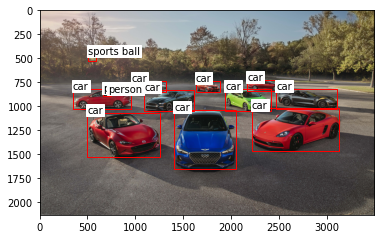

In [ ]:
showPreds(img, pred[0], iou_max_overlap=0.15, min_score=0.15, label_names=NAME)

# Homework , Due Nov 16th 

1. Now that you know how to enlarge a tensor after pooling, you can implement a convolutional auto-encoder using only the bottleneck approach. Go back to chapter 7 and re-implement a convolutional auto-encoder by using two rounds of pooling in the encoder countered by two rounds of transposed convolutions in the decoder. 
2. You may have noticed that transposed convolution can create some unevenly spaced _artifacts_ in it's output, which occur in our example diagram. These are not always a problem, but you can do better. Implement your own `Conv2dExpansion(n_filters_in)` class that takes the following approach: perform a convolution that has  `n_filters_in` in and `n_filters_in*4` filters out. This should result in a tensor of shape $(C*4, W, H)$. Then re-shape the output to $(C, W*2, H*2)$. This gives you a way to expand the output with convolutions without artifacts! 
3. Strided convolution can be used to shrink an image as an alternative to max-pooling. Modify the U-Net architecture to create a truly "fully convolutional" model by replacing all pooling with strided convolutions. How does the performance change?
4. Modify the Residual Network from Chapter 6 to use `nn.AdaptiveMaxPooling` followed by a linear hidden layer and then a linear layer to make predictions. Does this improve your results on FashionMNIST? Try comparing the original Residual Network and your adaptive pooling variant on CIFAR10 and see if there is a greater difference in performance. 
4. Modify the training loop of Faster R-CNN to include a test-pass that computes a test loss over a test set after each epoch of training. Hint: you will need to keep the model in `train` model since it's behavior changes when in `eval` mode!
